In [1]:
import sys

import blosc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('..')

from batch_generator import TwoMnistBatch
from dataset import Dataset
from dataset.opensets import MNIST

In [2]:
dset = MNIST(batch_class=TwoMnistBatch)

Extracting Extracting/tmp/train-images-idx3-ubyte.gz 
/tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gzExtracting
 /tmp/t10k-labels-idx1-ubyte.gz


In [3]:
ppl = (dset.train.p
       .create_color()
       .concatenate_images())

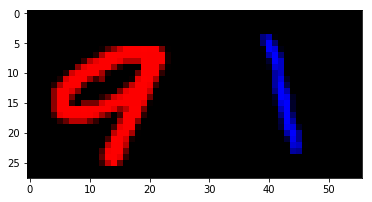

In [27]:
a = ppl.next_batch(15)
plt.imshow(a.images[0])